# Wykorzystanie metody Grad-CAM do analizy diagnozy sieci neuronowej wykrywającej zapalenie płuc
Na podstawie: [Grad-CAM class activation visualization](https://github.com/keras-team/keras-io/blob/master/examples/vision/grad_cam.py)

Z wykorzystaniem datasetu: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import os
import matplotlib.cm as cm

# Czytanie danych

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (150, 150))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [3]:
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)


# Przygotowywanie danych

In [4]:
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

x_train = x_train.reshape(-1, 150, 150, 1)
y_train = np.array(y_train)


x_test = x_test.reshape(-1, 150, 150, 1)
y_test = np.array(y_test)


def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 150, 150, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

x_train = to_rgb(x_train)
x_test = to_rgb(x_test)


# Tworzenie sieci

In [5]:
model = keras.Sequential(
    [
     keras.Input(shape=(150,150,3)),
     layers.Conv2D(32, 3, activation='relu'),
     layers.MaxPooling2D(),
     layers.Conv2D(64, 3, activation='relu'),
     layers.MaxPooling2D(),
     layers.Conv2D(64, 3, activation='relu'),
     layers.Flatten(),
     layers.Dense(10)
    ]
)

In [6]:
model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=keras.optimizers.Adam(),
  metrics=['accuracy']
)

# Tranowanie

In [7]:
model.fit(
        x_train, 
        y_train, 
        epochs=10, 
        batch_size=32, 
        validation_data = (x_test, y_test))

Epoch 1/10
163/163 [==============================] - 60s 363ms/step - loss: 0.2633 - accuracy: 0.8901 - val_loss: 1.0258 - val_accuracy: 0.7131
Epoch 2/10
163/163 [==============================] - 58s 357ms/step - loss: 0.1007 - accuracy: 0.9622 - val_loss: 0.8230 - val_accuracy: 0.7276
Epoch 3/10
163/163 [==============================] - 58s 354ms/step - loss: 0.0974 - accuracy: 0.9632 - val_loss: 0.8287 - val_accuracy: 0.7660
Epoch 4/10
163/163 [==============================] - 58s 354ms/step - loss: 0.0700 - accuracy: 0.9749 - val_loss: 1.0932 - val_accuracy: 0.7468
Epoch 5/10
163/163 [==============================] - 59s 360ms/step - loss: 0.0532 - accuracy: 0.9827 - val_loss: 1.3001 - val_accuracy: 0.7596
Epoch 6/10
163/163 [==============================] - 58s 358ms/step - loss: 0.0477 - accuracy: 0.9810 - val_loss: 1.3552 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 58s 356ms/step - loss: 0.0536 - accuracy: 0.9799 - val_loss: 0.9877 - val_ac

#  Warstwy modelu

In [8]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 73984)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                7

In [9]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions=np.where(predictions > 0.5, 1,0)

# Funkcja Grad-CAM

In [10]:
def gradcam(img, model, layer):
    inp = model.inputs
    layer=model.get_layer(layer).output
    out=model.output
    model = tf.keras.models.Model([inp], [layer, out])
    with tf.GradientTape() as tape:
        layer_output,grad = model(img)
        prediction = grad[:,tf.argmax(grad[0])]

    gradients = tape.gradient(prediction,layer_output)
    gradients = tf.reduce_mean(gradients,axis=(0,1,2))
    gradients = tf.expand_dims(gradients, -1)

    gradients = np.matmul(layer_output[0], gradients)
    gradients = gradients[:,:,-1]

    posheat_map = np.where(gradients < 0,0,gradients)
    maxheat_map=tf.math.reduce_max(gradients)
    gradcam = posheat_map / maxheat_map
    return gradcam

# Uruchomienie funkcji i wizualizacja

In [11]:
model.layers[-1].activation = None

Wykryto zapalenie płuc:
Nie


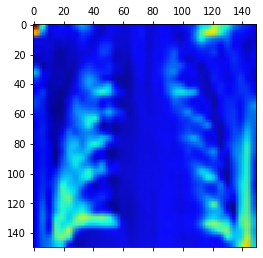

In [17]:
i=131
x=x_test[i]
original=x[np.newaxis,...]
        
print("Wykryto zapalenie płuc:")
if(predictions[i]==1):
    print("Tak")
else:
    print("Nie")   
       
img = gradcam(original,model,"conv2d_2")
img = np.uint8(255*img)

jet = cm.get_cmap("jet")
colors = jet(np.arange(256))[:, :3]

img = colors[img]
img = keras.preprocessing.image.array_to_img(img)
img = img.resize((150, 150))
img = keras.preprocessing.image.img_to_array(img)

img = img * 0.15 + original[0]
img = keras.preprocessing.image.array_to_img(img)


plt.matshow(img)
plt.show()